import libraries

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon
import sys

import project functions

In [2]:
sys.path.append("..")
from config import *

## H3

In [3]:
from h3 import h3

In [4]:
# import
# from __future__ import division
import warnings
warnings.filterwarnings('ignore')

#import pandas as pd
import shapely
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import mapping
import base64
import urllib
import tempfile
#import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='hex_lon', y='hex_lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])
    
    
def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['hex_lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['hex_lon'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

In [5]:
# # Visualize the OSM points
# osm_shp.plot(x='lon',y='lat',style='.',alpha=1,figsize=(6,6))
# plt.title('OSM points across London')

### Read the london_boundary_hex9_total_cnt

In [7]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

In [47]:
hex_df= pd.read_csv('../data output/1 london_boundary_hex9_total_digi_cnt.csv')

In [48]:
hex_df.head()

hex9  total_cnt
0  89194ac0007ffff          7
1  89194ac000bffff          3
2  89194ac001bffff          2
3  89194ac0023ffff          5
4  89194ac002bffff          3

Text(0.5, 1.0, 'hex-grid: POI total count')

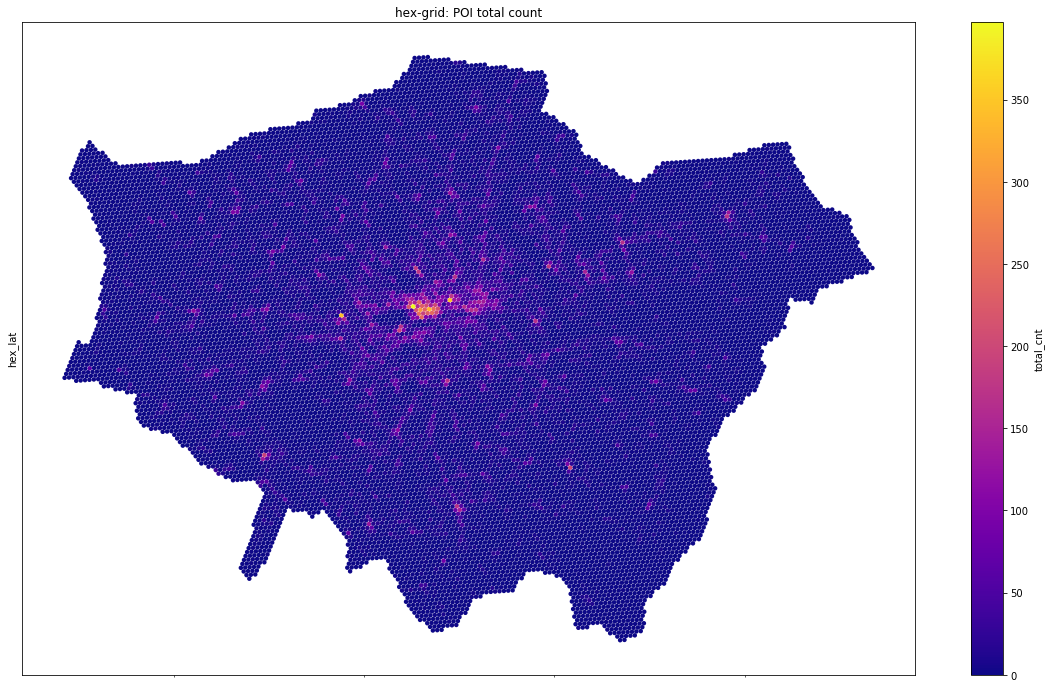

In [12]:
#find center of hex for visualization
hex_df['hex_lat'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
hex_df['hex_lon'] = hex_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(hex_df, metric_col='total_cnt', marker='o',figsize=(20,12),colormap='plasma')
plt.title('hex-grid: POI total count')

In [13]:
hex_df.sort_values(by='total_cnt', ascending=False).head()

hex9  total_cnt    hex_lat   hex_lon
8952  89195da49cfffff        397  51.514741 -0.148441
2889  89194ad32d7ffff        346  51.519175 -0.109843
4734  89194ada44bffff        344  51.508561 -0.224002
8936  89195da4987ffff        339  51.512869 -0.131628
8911  89195da4913ffff        299  51.512442 -0.140863

sum sanity check: 0.9999999999999999


Text(0.5, 1.0, 'POI density: 3-ring average')

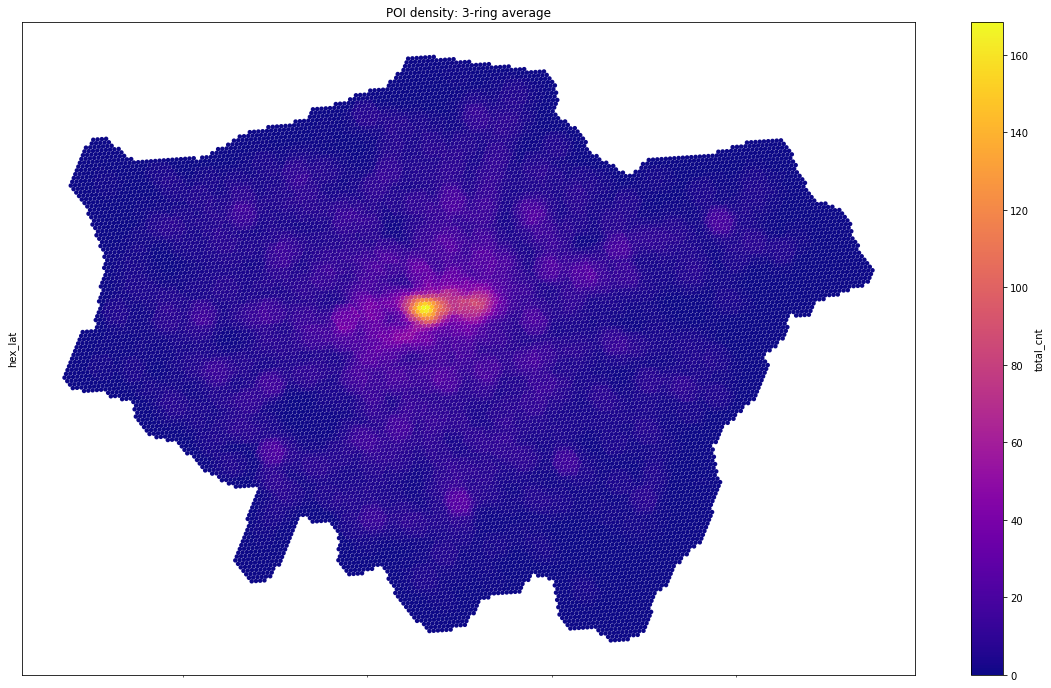

In [14]:
#kring_smoothing
k = 3
hex_df_s= kring_smoothing(hex_df, hex_col, metric_col='total_cnt', k=k)
print('sum sanity check:', hex_df_s['total_cnt'].sum() / hex_df['total_cnt'].sum() )
plot_scatter(hex_df_s, metric_col='total_cnt',figsize=(20,12), marker='o',colormap='plasma')
plt.title('POI density: 3-ring average')

In [15]:
hex_df_s.head()

hex9  total_cnt    hex_lat   hex_lon
0  89194ac0003ffff   4.837838  51.324624 -0.129289
1  89194ac0007ffff   4.405405  51.322108 -0.126339
2  89194ac000bffff   4.405405  51.324406 -0.133891
3  89194ac000fffff   4.513514  51.321890 -0.130941
4  89194ac0013ffff   3.081081  51.327357 -0.127636

In [16]:
hex_df_s.query('hex9 == "89194ac0003ffff"')

hex9  total_cnt    hex_lat   hex_lon
0  89194ac0003ffff   4.837838  51.324624 -0.129289

In [17]:
# hex_df_s.describe()

In [18]:
hex_df.query('hex9 == "89194ac0003ffff"')

hex9  total_cnt  shannon    hex_lat   hex_lon
12994  89194ac0003ffff          0      1.0  51.324624 -0.129289

In [19]:
# hex_df.describe()

In [18]:
from shapely import geometry
hex_df['geometry'] = hex_df[hex_col].apply(lambda x: geometry.Polygon(h3.h3_to_geo_boundary(x, geo_json=True)))

# hex_osm_g['geometry'] = 0
# for index, row in hex_osm_g.iterrows():
#     hex_osm_g.loc[index,'geometry'] = geometry.Polygon(h3.h3_to_geo_boundary(hex_osm_g.loc[index,hex_col], geo_json=True))

In [19]:
hex_df.head()

hex9  total_cnt    hex_lat   hex_lon  \
0  89194ac0007ffff          7  51.322108 -0.126339   
1  89194ac000bffff          3  51.324406 -0.133891   
2  89194ac001bffff          2  51.327139 -0.132239   
3  89194ac0023ffff          5  51.316859 -0.125043   
4  89194ac002bffff          3  51.316641 -0.129644   

                                            geometry  
0  POLYGON ((-0.1267717869416692 51.3238574587284...  
1  POLYGON ((-0.1343235898122116 51.3261555256425...  
2  POLYGON ((-0.1326712340835003 51.3288887247497...  
3  POLYGON ((-0.1254749973144384 51.3186085221158...  
4  POLYGON ((-0.1300764687368827 51.3183909248131...

In [20]:
hex_df.sort_values(by='total_cnt', ascending=False).head()

hex9  total_cnt    hex_lat   hex_lon  \
8952  89195da49cfffff        397  51.514741 -0.148441   
2889  89194ad32d7ffff        346  51.519175 -0.109843   
4734  89194ada44bffff        344  51.508561 -0.224002   
8936  89195da4987ffff        339  51.512869 -0.131628   
8911  89195da4913ffff        299  51.512442 -0.140863   

                                               geometry  
8952  POLYGON ((-0.1488752576875686 51.5164885568729...  
2889  POLYGON ((-0.1102760460479974 51.5209222353606...  
4734  POLYGON ((-0.2244394820353646 51.5103081413471...  
8936  POLYGON ((-0.1320616695487331 51.5146163544330...  
8911  POLYGON ((-0.1412967838748741 51.5141889580853...

In [21]:
gdf_all_hex = gpd.GeoDataFrame(hex_df, geometry='geometry', crs={'init': 'epsg:4326'})

In [22]:
gdf_all_hex.head()

hex9  total_cnt    hex_lat   hex_lon  \
0  89194ac0007ffff          7  51.322108 -0.126339   
1  89194ac000bffff          3  51.324406 -0.133891   
2  89194ac001bffff          2  51.327139 -0.132239   
3  89194ac0023ffff          5  51.316859 -0.125043   
4  89194ac002bffff          3  51.316641 -0.129644   

                                            geometry  
0  POLYGON ((-0.1267717869416692 51.3238574587284...  
1  POLYGON ((-0.1343235898122116 51.3261555256425...  
2  POLYGON ((-0.1326712340835003 51.3288887247497...  
3  POLYGON ((-0.1254749973144384 51.3186085221158...  
4  POLYGON ((-0.1300764687368827 51.3183909248131...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff422b0e4a8>]],
      dtype=object)

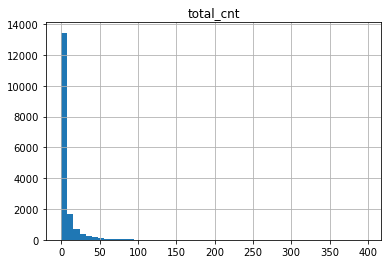

In [23]:
gdf_all_hex.hist(column='total_cnt',bins=50)

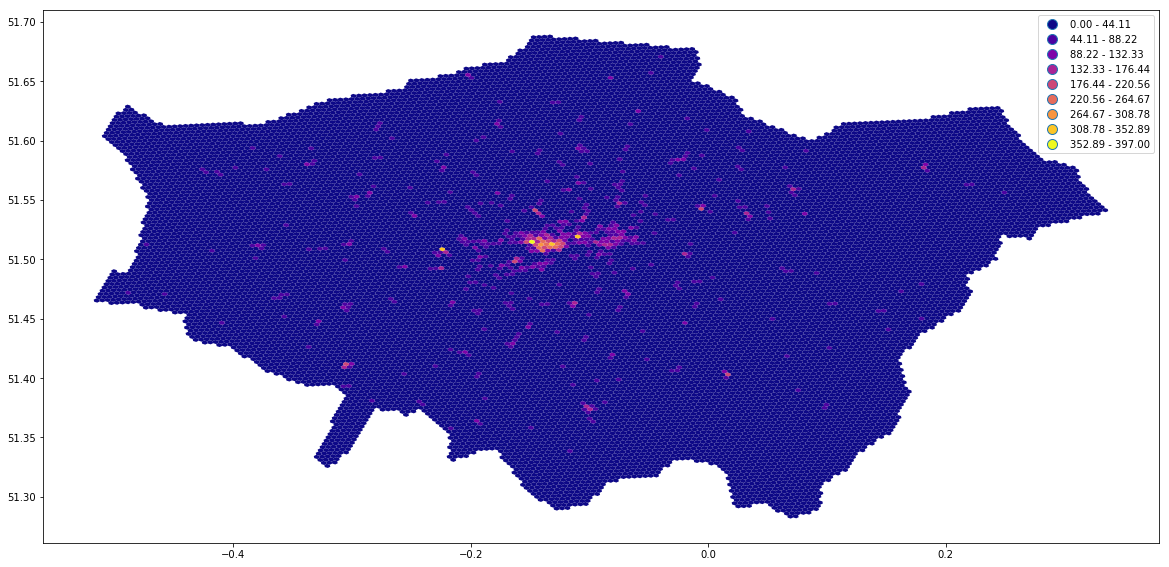

In [36]:
#https://github.com/pysal/mapclassify
scheme = 'equal_interval'
colors = 9
cmap = 'plasma'
figsize = (20,12)
gdf_all_hex.plot(column='total_cnt', cmap=cmap, figsize=figsize, scheme=scheme, k=colors, legend=True)

### Chloropleth from hex 

In [30]:
import branca
import folium

#https://stackoverflow.com/questions/47846744/create-an-asymmetric-colormap
import branca.colormap as cm
# colormap = cm.LinearColormap(colors=['red','blue'], index=[-200,0],vmin=-200,vmax=1200)

#https://python-visualization.github.io/folium/quickstart.html
from branca.colormap import linear
#https://github.com/python-visualization/branca/blob/master/branca/_schemes.json
colormap = linear.YlOrRd_03.scale(
    gdf_all_hex.total_cnt.min(),
    gdf_all_hex.total_cnt.max())

#colormap = cm.LinearColormap(colors=['red','lightblue','blue'], index=[gdf_all_hex.cnt_x.min(),2,gdf_all_hex.cnt_x.max()],vmin=gdf_all_hex.cnt_x.min(),vmax=gdf_all_hex.cnt_x.max())

osm_cnt_series = gdf_all_hex.set_index(hex_col)['total_cnt']

def style_function(feature):
    count = osm_cnt_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0.5,
        'weight': 2,
        'color':'#black' if count is None else colormap(count),
        'opacity':1,
        'fillColor': '#black' if count is None else colormap(count)
    }

In [32]:
m = folium.Map(
    location=[51.509091, -0.124038],
    tiles='cartodbpositron',
    zoom_start=10
)

# not all can be visualised on jupyter
folium.GeoJson(
    gdf_all_hex[:500].__geo_interface__,
    name='geojson',
    style_function=style_function
).add_to(m)


folium.LayerControl().add_to(m)

m#.save('DIGI_density_leaflet.html')

In [29]:
# convert geodataframe to json
#gdf_all_hex[:10].__geo_interface__
# or 
# gdf_all_hex.geometry.to_json()
# or save it as a json file and open it
# gdf_all_hex.to_file("my_geojson_file.json", driver = "GeoJSON")
# open_json = os.path.join('my_geojson_file.json')

### Load Census UK Data 

we can pick any census data and their statistical unit areas

In [49]:
# http://ukdataexplorer.com/census/london/

#https://data.london.gov.uk/dataset/ward-profiles-and-atlas
ct_data_link = "../../data/Census/population_density_wards_2011_census.csv"
#https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
ct_shape_link = '../../data/Census/statistical-gis-boundaries-london/ESRI/London_Ward_2011_new.shp'

Text(0.5, 1.0, 'Census 2011: Ward Population Density')

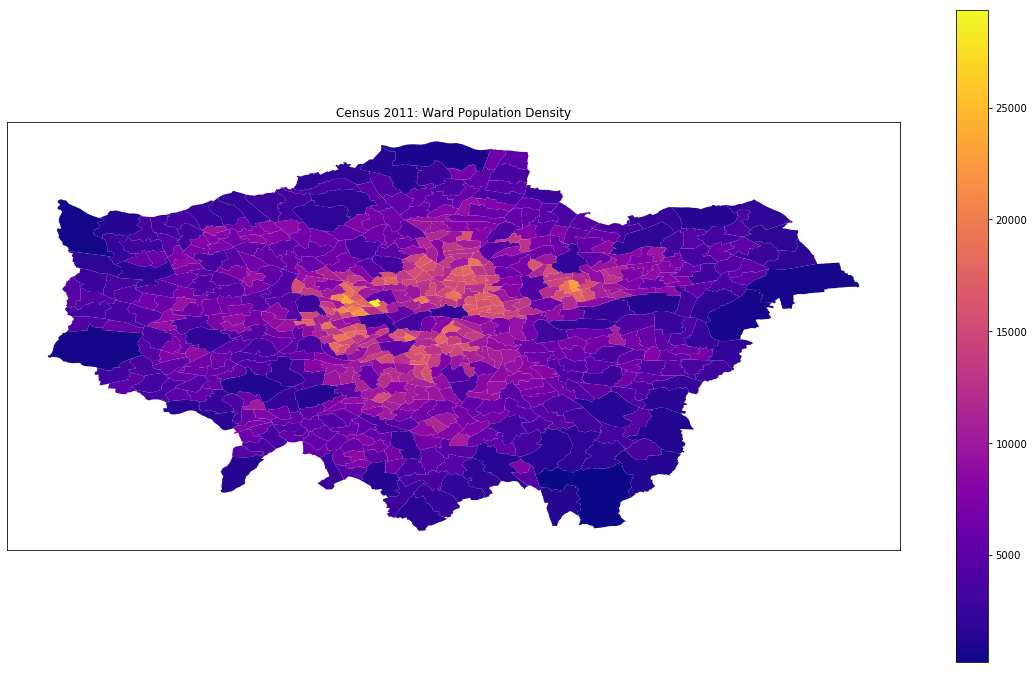

In [50]:
METRIC_COL = 'Population density km' #population density

# Load Ward ShapeFile
ct_gdf=GeoDataFrame.from_file(ct_shape_link)
ct_gdf.rename(columns={'geo_code':'New Code'},inplace=True)
ct_gdf['New Code'] = ct_gdf['New Code'].astype(str) 

# Load Ward Population Density
df = pd.read_csv(ct_data_link, usecols=['New Code','Population density km'])
df['New Code'] = df['New Code'].astype(str)

# join metadata
newdf = df.merge(ct_gdf).fillna(0)
gdf = gpd.GeoDataFrame(newdf, geometry='geometry', crs = {"init": "epsg:4326"})

# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(20,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
gdf.plot(column=METRIC_COL,colormap='plasma',alpha=1,linewidth=0.05,ax=ax, legend=True)
plt.title('Census 2011: Ward Population Density')

### Census to H3 

In [38]:
# from shapely.ops import cascaded_union
# union_poly.geometry
# # # Unify the Ward boundaries and get the json for h3 polyfill
# union_poly = cascaded_union(gdf.geometry)
# union_poly_gdf = gpd.GeoDataFrame(gpd.GeoSeries(union_poly))
# union_poly_gdf = union_poly_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
# union_poly_gdf_json = union_poly_gdf.geometry[0].__geo_interface__

# create Point object based on hex latlng
gdf_all_hex['hex_centroid_geometry'] = gdf_all_hex.apply(lambda x: shapely.geometry.Point(x.hex_lon,x.hex_lat),1)
gdf_all_hex.set_geometry('hex_centroid_geometry',inplace=True)

# # plot hex latlng but first convert the geodataframe into dataframe
# pd.DataFrame(gdf_all_hex).plot(x='hex_lon',y='hex_lat',style='.',alpha=.1,figsize=(20,12));
# plt.title('hex-grid: London')

# Intersect Hex Point with CT Polygon
gdf_ct = gpd.tools.sjoin(gdf[['Population density km', 'geometry']], gdf_all_hex, how="inner")
gdf_ct.sample(3)

print('Sanity Check\nnumber of hexes:', len(gdf_ct))
print('number of no census hexes:', len(gdf_all_hex) - len(gdf_ct))

# # convert the geodataframe to dataframe to visualize
# df_ct = pd.DataFrame(gdf_ct)
# plot_scatter(df_ct, metric_col=METRIC_COL, figsize=(20,12), marker='.',colormap='plasma')
# plt.title('hex-grid: population density')

Sanity Check
number of hexes: 16524
number of no census hexes: 523


In [39]:
gdf_ct.head()

Population density km                                      geometry_left  \
0                 2312.5  POLYGON ((-0.08812915064452524 51.519410726114...   
0                 2312.5  POLYGON ((-0.08812915064452524 51.519410726114...   
0                 2312.5  POLYGON ((-0.08812915064452524 51.519410726114...   
0                 2312.5  POLYGON ((-0.08812915064452524 51.519410726114...   
0                 2312.5  POLYGON ((-0.08812915064452524 51.519410726114...   

   index_right             hex9  total_cnt    hex_lat   hex_lon  \
0         2760  89194ad3043ffff        109  51.514783 -0.090079   
0         2885  89194ad32c7ffff         76  51.516449 -0.111501   
0         2872  89194ad328bffff         76  51.516661 -0.106885   
0         2870  89194ad3283ffff         66  51.516874 -0.102268   
0         2875  89194ad3297ffff         51  51.517086 -0.097652   

                                      geometry_right  
0  POLYGON ((-0.09051101440384639 51.516530228430...  
0  POLYGON ((-0.1119347023431796 51.5181956146964...  
0  POLYGON ((-0.1073178019435606 51.5184081414355...  
0  POLYGON ((-0.1027010503906024 51.5186204781293...  
0  POLYGON ((-0.09808444773710553 51.518832624796...

### Add the census info to the initial hex_df

In [40]:
hex_df_census = pd.merge(gdf_ct[['Population density km', hex_col]], hex_df, how='right', on=hex_col)
hex_df_census.fillna(0,inplace=True)

Text(0.5, 1.0, 'Census: h3')

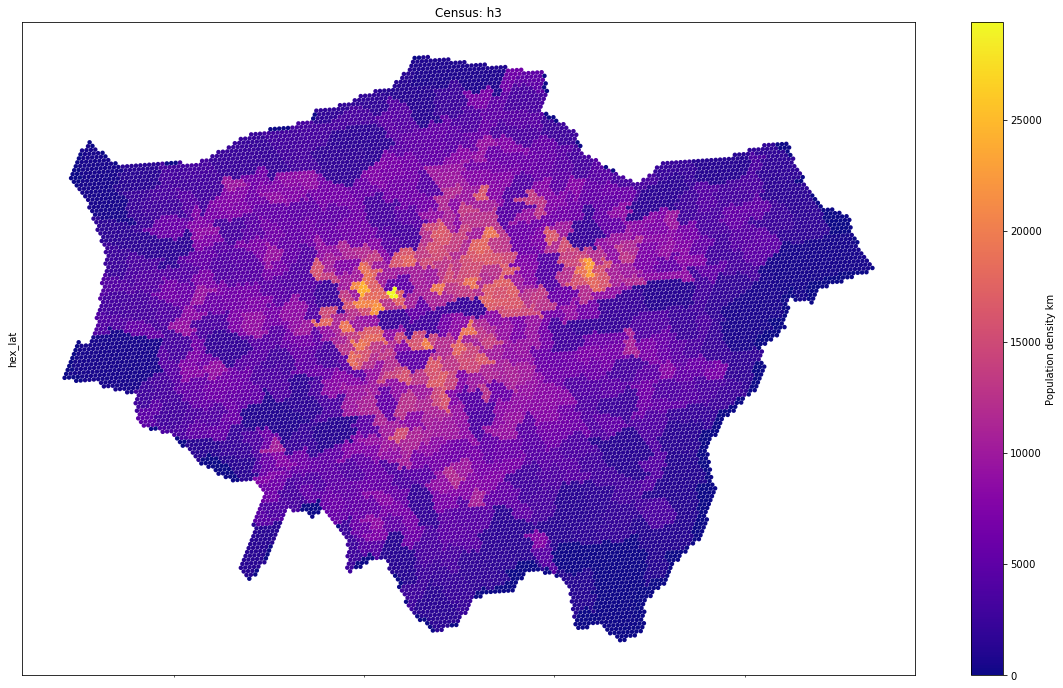

In [41]:
plot_scatter(hex_df_census, metric_col='Population density km',figsize=(20,12), marker='o',colormap='plasma')
plt.title('Census: h3')

sum sanity check: 1.0


Text(0.5, 1.0, 'Census: 1-ring average')

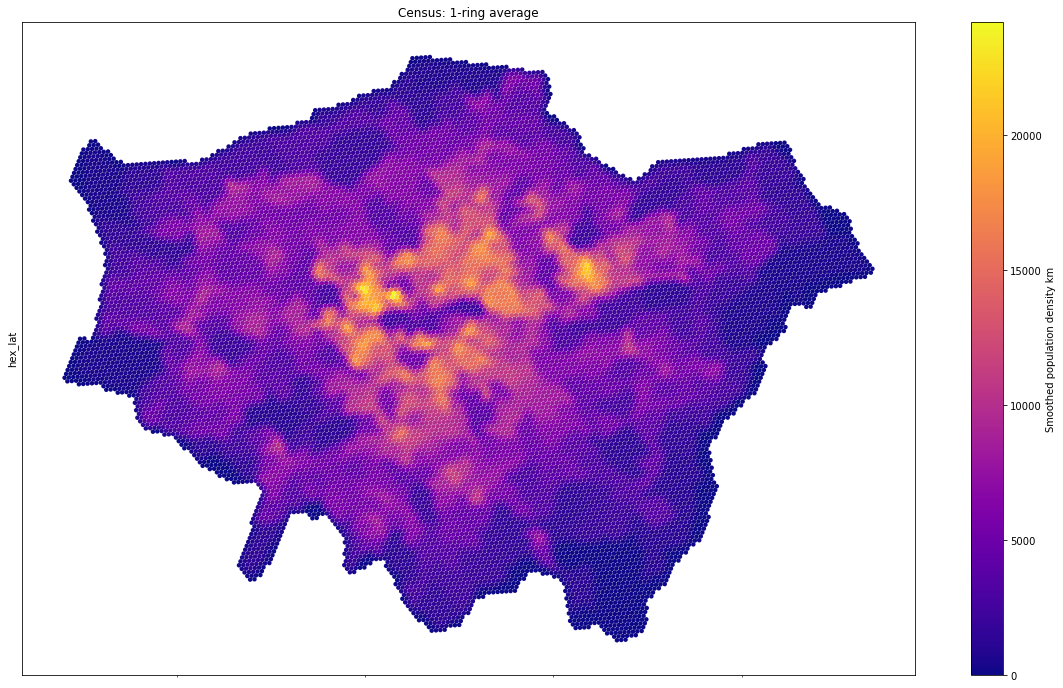

In [42]:
#kring_smoothing
k = 1
census_col_name = "Population density km"
smooth_census_col_name = "Smoothed population density km"
hex_df_census_s= kring_smoothing(hex_df_census, hex_col, metric_col=census_col_name, k=k)
hex_df_census_s.rename(columns={census_col_name:smooth_census_col_name}, inplace=True)
print('sum sanity check:', hex_df_census_s[smooth_census_col_name].sum() / hex_df_census[census_col_name].sum() )
plot_scatter(hex_df_census_s, metric_col=smooth_census_col_name,figsize=(20,12), marker='o',colormap='plasma')
plt.title('Census: 1-ring average')

In [43]:
hex_df_census = pd.merge(hex_df_census_s[[smooth_census_col_name, hex_col]], hex_df_census, how='right', on=hex_col)
hex_df_census.fillna(0,inplace=True)

In [44]:
hex_df_census.head()

Smoothed population density km             hex9  Population density km  \
0                     2220.142857  89194ac0003ffff                 1597.4   
1                     1905.114286  89194ac0007ffff                 2315.4   
2                     2384.971429  89194ac000bffff                 2700.0   
3                     2015.000000  89194ac000fffff                 1597.4   
4                     2322.714286  89194ac0013ffff                 2315.4   

   total_cnt    hex_lat   hex_lon  \
0          0  51.324624 -0.129289   
1          7  51.322108 -0.126339   
2          3  51.324406 -0.133891   
3          0  51.321890 -0.130941   
4          0  51.327357 -0.127636   

                                            geometry  \
0  POLYGON ((-0.1297213437793733 51.3263731245818...   
1  POLYGON ((-0.1267717869416692 51.3238574587284...   
2  POLYGON ((-0.1343235898122116 51.3261555256425...   
3  POLYGON ((-0.1313737255520153 51.3236399234682...   
4  POLYGON ((-0.1280688281952681 51.3291061979874...   

                           hex_centroid_geometry  
0  POINT (-0.1292889328000179 51.32462352352295)  
1  POINT (-0.1263394957776667 51.32210783511487)  
2  POINT (-0.1338910230764753 51.32440590391284)  
3  POINT (-0.1309412786487178 51.32189027917605)  
4  POINT (-0.1276364531478285 51.32735664016788)

In [45]:
# the same as the initial gdf
len(hex_df_census)

17047

In [46]:
# hex_df_census[[smooth_census_col_name, census_col_name, hex_col]].\
# to_csv('./5 london_boundary_hex9_census.csv', index=False)

### Export as shapefile with polygon geometry as primary geometry 

In [45]:
hex_gdf_census = gpd.GeoDataFrame(hex_df_census, geometry='geometry', crs={'init': 'epsg:4326'})

In [46]:
# hex_gdf_census.drop(['hex_centroid_geometry'], axis=1, inplace=True)
# hex_gdf_census.to_file(filename= "all_hex_digi_poi_total_cnt_diversity_census_with_geom.shp" , driver = 'ESRI Shapefile')